Found 1153 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Epoch 1/30
73/73 [==============================] - 74s 803ms/step - loss: 0.7449 - accuracy: 0.5672 - val_loss: 0.6683 - val_accuracy: 0.5958
Epoch 2/30
73/73 [==============================] - 53s 731ms/step - loss: 0.6603 - accuracy: 0.6106 - val_loss: 0.6606 - val_accuracy: 0.6202
Epoch 3/30
73/73 [==============================] - 53s 732ms/step - loss: 0.6513 - accuracy: 0.6193 - val_loss: 0.6666 - val_accuracy: 0.6167
Epoch 4/30
73/73 [==============================] - 54s 735ms/step - loss: 0.6561 - accuracy: 0.6236 - val_loss: 0.6587 - val_accuracy: 0.6272
Epoch 5/30
73/73 [==============================] - 53s 733ms/step - loss: 0.6441 - accuracy: 0.6305 - val_loss: 0.6552 - val_accuracy: 0.6307
Epoch 6/30
73/73 [==============================] - 54s 746ms/step - loss: 0.6352 - accuracy: 0.6479 - val_loss: 0.6530 - val_accuracy: 0.6132
Epoch 7/30
73/73 [==============================] - 53s 723

C:\Users\KIIT\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


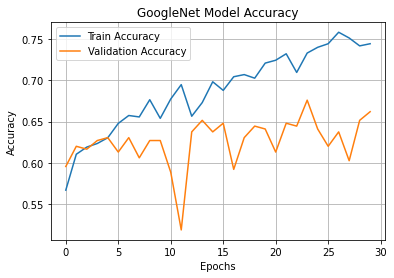

18/18 [==============================] - 10s 466ms/step
Accuracy: 0.5157
Precision: 0.5805
Recall (Sensitivity): 0.6919
F1 Score: 0.6313
AUC-ROC: 0.4683
Specificity: 0.2522
K-score: 0.5157


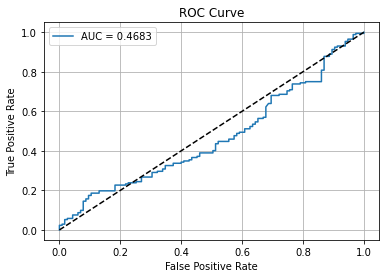

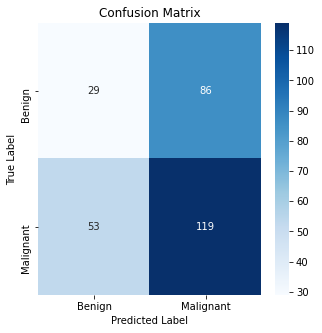

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Image Data Preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory('augmented_images', target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                         class_mode='binary', subset='training')
val_data = datagen.flow_from_directory('augmented_images', target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                       class_mode='binary', subset='validation')

# Load Pre-trained Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_data, validation_data=val_data, epochs=30)

# Save Model
model.save('googlenet_model.h5')

# Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GoogleNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Get Predictions
y_true = val_data.classes
y_pred_prob = model.predict(val_data)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
k_score = (tp + tn) / (tp + tn + fp + fn)  # Kappa Score approximation

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"K-score: {k_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
